# Машинное обучение, ФКН ВШЭ

# Практическое задание 13. Рекомендательные системы

## Общая информация
**Дата выдачи: 01.06.2025**

**Мягкий дедлайн: 14.06.2025 23:59 MSK**

**Жёсткий дедлайн: 16.06.2025 23:59 MSK**

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — **11** баллов + **2.5** бонусных.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-13-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

## О задании

В этой работе мы будем решать задачу рекомендации музыки. То есть мы поставим целью получить модель, которая для каждого пользователя будет возвращать набор треков, наиболее похожих на те, что он уже слушал. В первой части мы разберемся с memory-based подходом и моделью со скрытыми переменными. Это не очень мощные методы, но зато они позволяют строить предсказания почти моментально. Затем, во второй части, мы обратим внимание на то, что датасет содержит огромное число треков и воспользуемся результатами уже построенных быстрых моделей для сокращения списка кандидатов до разумного количества. После этого проведем ранжирование среди кандидатов с помощью сильной, но чуть более медленной модели, и отберем самые лучшие варианты. Такой двухэтапный алгоритм построения рекомендаций изображен на картинке.


![photo_2023-05-17%2020.06.18.jpeg](attachment:photo_2023-05-17%2020.06.18.jpeg)

Приступим!

Все шаблоны ниже можно переписывать по своему усмотрению.

In [1]:
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from typing import Callable, List

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as scs

In [2]:
ratings = pd.read_csv('music_dataset.csv')
ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [3]:
tracks_info = pd.read_csv('tracks_info.csv')
tracks_info.head()

,id,name,artists
0,0,What There Is,['a-ha']
1,1,I'll Play The Blues For You,['Albert King']
2,2,Breaking Up Somebody's Home,['Albert King']
3,3,Imma Be,['Black Eyed Peas']
4,4,Boom Boom Pow,['Black Eyed Peas']


Для оценки качества рекомендаций мы будем использовать метрику $MAP@k$.

$$
MAP@k = \frac{1}{N} \sum_{u = 1}^N AP_u@k
$$
$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)$$


*   $N$ - количество пользователей.
*   $n_u$ - число релевантных треков пользователя $u$ на тестовом промежутке.
*   $r_u(i)$ - бинарная величина: относится ли трек на позиции $i$ к релевантным.

**Задание 1 (0.5 балл).** Реализуйте метрику $MAP@k$.

In [4]:
def mapk(relevant: List[List[int]], predicted: List[List[int]], k: int = 20) -> float:

    average_precisions = []

    for rel, pred in zip(relevant, predicted):

        pred = pred[:k]


        precisions = []
        relevant_items = set(rel)
        num_relevant = len(relevant_items)

        if num_relevant == 0:

            average_precisions.append(0.0)
            continue

        correct = 0
        for i, item in enumerate(pred, 1):
            if item in relevant_items:
                correct += 1
                precisions.append(correct / i)

        if precisions:
            avg_precision = sum(precisions) / min(num_relevant, k)
        else:
            avg_precision = 0.0

        average_precisions.append(avg_precision)

    return sum(average_precisions) / len(average_precisions) if average_precisions else 0.0

In [5]:
relevant = [
    [1, 7, 6, 2, 8],
    [1, 5, 4, 8],
    [8, 2, 5]
]

pred = [
    [8, 1, 5, 0, 7, 2, 9, 4],
    [0, 1, 8, 5, 3, 4, 7, 9],
    [9, 2, 0, 6, 8, 5, 3, 7]
]

assert round(mapk(relevant, pred, k=5), 4) == 0.4331

Разделим данные на тренировочные и тестовые так, чтобы в теcтовый датасет попали 50 последних треков каждого пользователя.

In [6]:
def train_test_split(ratings):
    train_ratings, test_ratings = [], []
    num_test_samples = 50

    # getting train samples
    for userId, user_data in tqdm(ratings.groupby('userId')):
        train_ratings += [user_data[:-num_test_samples]]

    train_ratings = pd.concat(train_ratings).reset_index(drop=True)
    all_train_items = train_ratings['trackId'].unique()

    # getting train samples
    # we drop all tracks that are not presented it the training samples,
    # because we won't be able to learn representations for them
    for userId, user_data in tqdm(ratings.groupby('userId')):
        test_items = user_data[-num_test_samples:]
        test_items = test_items[np.isin(test_items['trackId'], all_train_items)]
        test_ratings += [test_items]

    test_ratings = pd.concat(test_ratings).reset_index(drop=True)

    return train_ratings, test_ratings

In [7]:
train_ratings, test_ratings = train_test_split(ratings)

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Почистим табличку с информацией о треках и закодируем id треков так, чтобы они соответствовали их порядковому номеру.

In [8]:
redundant_rows = np.where(~np.isin(tracks_info['id'], train_ratings['trackId'].unique()))[0]
tracks_info.drop(redundant_rows, inplace=True)
tracks_info = tracks_info.reset_index(drop=True)

In [9]:
def ids_encoder(ratings):
    users = sorted(ratings['userId'].unique())
    items = sorted(ratings['trackId'].unique())

    # create users and items encoders
    uencoder = LabelEncoder()
    iencoder = LabelEncoder()

    # fit users and items ids to the corresponding encoder
    uencoder.fit(users)
    iencoder.fit(items)

    return uencoder, iencoder

In [10]:
uencoder, iencoder = ids_encoder(train_ratings)
train_ratings['trackId'] = iencoder.transform(train_ratings['trackId'].tolist())
test_ratings['trackId'] = iencoder.transform(test_ratings['trackId'].tolist())
tracks_info['id'] = iencoder.transform(tracks_info['id'].tolist())

In [11]:
train_ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [12]:
test_ratings.head()

,userId,trackId
0,0,57582
1,0,57802
2,0,57957
3,0,58174
4,0,59168


Соберем все релевантные треки для каждого пользователя в список.

In [13]:
test_relevant = []
test_users = []
for user_id, user_data in test_ratings.groupby('userId'):
    test_relevant += [user_data['trackId'].tolist()]
    test_users.append(user_id)

**Задание 2 (0.5 балла).** Реализуйте метод `get_test_recommendations` в классе `BaseModel`. Он принимает на вход параметр `k` и возвращает массив из `k` наиболее подходящих треков для каждого пользователя. Не забывайте удалять уже прослушанные треки из рекомендуемых.

In [15]:
class BaseModel:
    def __init__(self, ratings: pd.DataFrame):
        self.ratings = ratings
        self.n_users = len(np.unique(self.ratings['userId']))
        self.n_items = len(np.unique(self.ratings['trackId']))

        self.R = np.zeros((self.n_users, self.n_items))
        self.R[self.ratings['userId'], self.ratings['trackId']] = 1.

    def recommend(self, uid: int):
        """
        param uid: int - user's id
        return: [n_items] - vector of recommended items sorted by their scores in descending order
        """
        raise NotImplementedError

    def remove_train_items(self, preds: List[List[int]], k: int):
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = preds[user_id]
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]

        return new_preds

    def get_test_recommendations(self, k: int):
        test_preds = []
        for user_id in range(self.n_users):
            preds = self.recommend(user_id)
            test_preds.append(preds)

        test_preds = self.remove_train_items(test_preds, k)

        return test_preds[test_users]



### Часть 1. Коллаборативная фильтрация (User2User)

Идея: чтобы выбрать треки, которые понравятся пользователю, можно набрать несколько похожих на него пользователей (соседей) и посмотреть, какие треки они слушают. После этого остается агрегировать треки этих пользователей и выбрать самые популярные. Соответственно, задача состоит из двух частей: выбора функции похожести двух пользователей и способа агрегации.

В качестве функции похожести мы будем использовать меру Жаккара:

$$ s(u, v) = \frac{|I_u \cap I_v|}{|I_u \cup I_v|} $$


Во всех формулах
* $I_u$ - множество треков, прослушанных пользователем $u$.
* $r_{ui}$ - прослушал ли пользователь $u$ трек $i$ (0 или 1).

Множество соседей определим как $$N(u) = \{ v \in U \setminus \{u\} \mid s(u, v) > \alpha\},$$ где $\alpha \, - $ гиперпараметр.



Для агрегации мы будем пользоваться следующей формулой.
$$
\hat{r}_{ui} = \frac{\sum_{v \in N(u)} s(u, v) r_{vi}}{\sum_{v \in N(u)} |s(u, v)|}
$$

**Задание 3.2 (0.5 балла).** Реализуйте функцию подсчета меры Жаккара.

Функция принимает матрицу оценок и вектор оценок пользователя $u$ и возвращает вектор со значениями похожести пользователя $u$ на всех пользователей. Старайтесь писать оптимизированный код, за неэффективную реализацию оценка может быть снижена.

In [16]:

def jaccard(ratings: np.array, user_vector: np.array) -> np.array:
    numerator = ratings@user_vector.T
    denominator = np.sum(ratings+user_vector!=0,1)

    sim_scores = np.divide(numerator, denominator)
    sim_scores[sim_scores == 1] = -1
    return sim_scores


**Задание 4 (1 балл).** Реализуйте методы `similarity` и `recommend` класса `User2User`. `recommend` возвращает индексы треков, отсортированные в порядке убывания предсказанных оценок. Значение парамметра `alpha` можно менять по своему усмотрению так, чтобы оно было разумным.

In [35]:
class User2User(BaseModel):
    def __init__(self, ratings, similarity_func):
        super().__init__(ratings)

        assert similarity_func in [jaccard]

        self.similarity_func = similarity_func
        self.alpha = 0.02

    def similarity(self, user_vector: np.array):
        """
        user_vector: [n_items]
        """
        sim_scores = np.asarray(self.similarity_func(self.R,user_vector)).squeeze()
        mask = sim_scores > self.alpha
        sim_scores = sim_scores[mask]

        numerator = sim_scores @ self.R[mask]
        denominator = np.sum(sim_scores)

        return numerator/denominator



    def recommend(self, uid: int):
        user_vector = self.R[uid]
        similarities = self.similarity(user_vector)
        return np.argsort(similarities)[::-1]

**Задание 5 (0.5 балл).** Постройте график зависимости значений $MAP@k$ от разных $k$ при рекомендации на основе меры Жаккара, сравните его с рекомендициями самых популярных треков и случайных. Какой из трех способов рекомендаций оказался лучшим?

In [36]:
track_popularity = train_ratings.groupby('trackId').size().reset_index(name='count')
popular_tracks = track_popularity.sort_values('count', ascending=False)['trackId'].tolist()


In [37]:
from random import sample
from tqdm import tqdm
import time

k_val = list(range(1,15))



mapk_jaccard = []
mapk_random = []
mapk_popular = []



model_jaccard = User2User(train_ratings, jaccard)



n_user = model_jaccard.n_users
all_tracks = list(range(model_jaccard.n_items))
start_time = time.time()

for k in tqdm(k_val):

    recomends_jaccard = model_jaccard.get_test_recommendations(k)

    recomends_random = []

    for _ in range(n_user):
        recomends_random.append(sample(all_tracks, k))

    recomends_popular = [popular_tracks[:k] for _ in range(n_user)]


    map_j = mapk(test_relevant, recomends_jaccard, k)
    map_r = mapk(test_relevant, recomends_random, k)
    map_p = mapk(test_relevant, recomends_popular, k)


    mapk_jaccard.append(map_j)
    mapk_random.append(map_r)
    mapk_popular.append(map_p)

    elapsed = time.time() - start_time
    avg_time = elapsed / (k_val.index(k) + 1)
    remaining = avg_time * (len(k_val) - k_val.index(k) - 1)
    tqdm.write(f"Осталось: ~{remaining:.1f} сек")


  0%|          | 0/14 [00:00<?, ?it/s]<ipython-input-35-411944955>:21: RuntimeWarning: invalid value encountered in divide
  return numerator/denominator
<ipython-input-15-3316012668>:26: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]
  7%|▋         | 1/14 [00:25<05:36, 25.89s/it]

Осталось: ~336.6 сек


 14%|█▍        | 2/14 [00:51<05:08, 25.73s/it]

Осталось: ~309.0 сек


 21%|██▏       | 3/14 [01:17<04:42, 25.70s/it]

Осталось: ~282.9 сек


 29%|██▊       | 4/14 [01:42<04:16, 25.61s/it]

Осталось: ~256.6 сек


 36%|███▌      | 5/14 [02:08<03:49, 25.53s/it]

Осталось: ~230.5 сек


 43%|████▎     | 6/14 [02:33<03:24, 25.57s/it]

Осталось: ~204.9 сек


 50%|█████     | 7/14 [02:59<02:59, 25.57s/it]

Осталось: ~179.3 сек


 57%|█████▋    | 8/14 [03:24<02:31, 25.32s/it]

Осталось: ~153.0 сек


 64%|██████▍   | 9/14 [03:48<02:05, 25.04s/it]

Осталось: ~126.9 сек


 71%|███████▏  | 10/14 [04:13<01:40, 25.06s/it]

Осталось: ~101.4 сек


 79%|███████▊  | 11/14 [04:38<01:15, 25.17s/it]

Осталось: ~76.1 сек


 86%|████████▌ | 12/14 [05:04<00:50, 25.32s/it]

Осталось: ~50.8 сек


 93%|█████████▎| 13/14 [05:30<00:25, 25.43s/it]

Осталось: ~25.4 сек


100%|██████████| 14/14 [05:56<00:00, 25.43s/it]

Осталось: ~0.0 сек


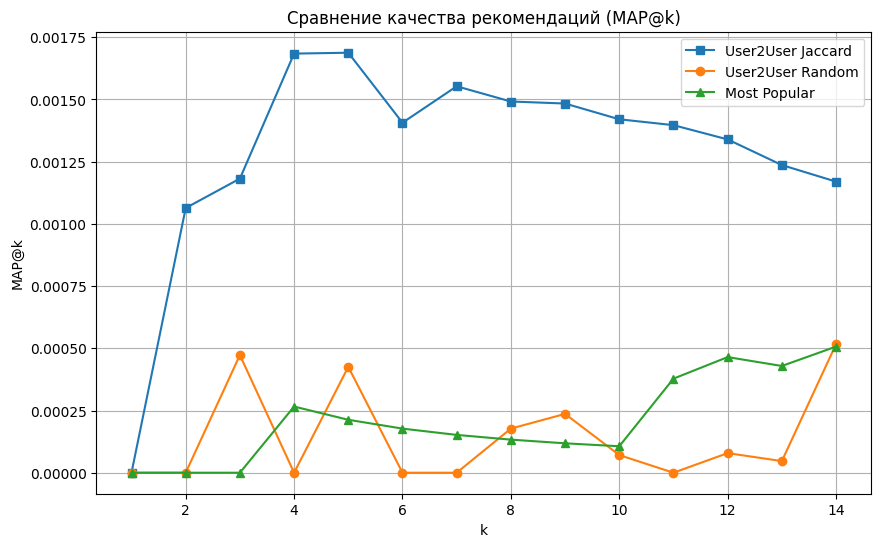

In [38]:
plt.figure(figsize=(10, 6))

plt.plot(k_val, mapk_jaccard, marker='s', label='User2User Jaccard')
plt.plot(k_val, mapk_random, marker='o', label='User2User Random')
plt.plot(k_val, mapk_popular, marker='^', label='Most Popular')

plt.xlabel('k')
plt.ylabel('MAP@k')
plt.title('Сравнение качества рекомендаций (MAP@k)')
plt.grid(True)
plt.legend()
plt.show()

Как мы можем заметить, лучше всех проявила себя такая функция схожести, как Жаккара, поэтому далее будем использовать ее.

**Бонус (1 балла).** Как вы могли заметить, матрица оценок получается очень разреженной, но мы работаем с ней как с обычной, это не дело. Перепишите код так, чтобы все методы могли работать с разреженными матрицами и сравните скорость работы такого подхода с оригинальным.

In [39]:

start = time.time()
model_d = User2User(ratings, similarity_func=jaccard)
model_d.get_test_recommendations(k=14)
print("Base time:", time.time() - start)

<ipython-input-35-411944955>:21: RuntimeWarning: invalid value encountered in divide
  return numerator/denominator
<ipython-input-15-3316012668>:26: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]


Base time: 27.767235279083252


In [40]:
from scipy.sparse import csr_matrix

In [44]:

class User2User_improved(BaseModel):
    def __init__(self, ratings, similarity_func):
        super().__init__(ratings)

        assert similarity_func in [jaccard]

        self.similarity_func = similarity_func
        self.alpha = 0.02
        self.R = csr_matrix(self.R) # чтобы полностью с разреженной не работать

    def similarity(self, user_vector: np.array):
        """
        user_vector: [n_items]
        """
        user_vector = user_vector.toarray()
        sim_scores = np.asarray(self.similarity_func(self.R,user_vector)).squeeze()
        mask = sim_scores > self.alpha
        sim_scores = sim_scores[mask]

        numerator = sim_scores @ self.R[mask]
        denominator = np.sum(sim_scores)

        return numerator/denominator



    def recommend(self, uid: int):
        user_vector = self.R[uid]
        similarities = self.similarity(user_vector)
        return np.argsort(similarities)[::-1]


In [45]:
start = time.time()
model = User2User_improved(ratings, similarity_func=jaccard)
model.get_test_recommendations(k=14)
print("Base time:", time.time() - start)

<ipython-input-44-1838412362>:23: RuntimeWarning: invalid value encountered in divide
  return numerator/denominator
<ipython-input-15-3316012668>:26: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]


Base time: 17.763691663742065


Результаты наглядно показывают, что улучшенный метод сильно позволил сэкономить время, так мы работаем не полностью с разреженной матрицей, а только с ненулевыми элементами.



Мы можем посмотреть глазами, насколько хорошо модель рекомендует треки. Для этого сравним уже прослушанные треки с рекомендованными и релевантными для случайного пользователя. Хорошо ли у вас получилось?

In [120]:
user_id = np.random.randint(0, model.n_users)

In [121]:
listened_tracks = train_ratings[train_ratings.userId == user_id].trackId[:15]

print('Already listened tracks:')

tracks_info.loc[listened_tracks][['name', 'artists']]

Already listened tracks:


,name,artists
234,Wind Of Change,['Scorpions']
396,The Phantom Of The Opera,"['Nightwish', 'Andrew Lloyd Webber']"
411,Don't Cry,"[""Guns N' Roses""]"
422,Stan,"['Eminem', 'Dido']"
474,Tom's Diner,"['DNA', 'Suzanne Vega', 'Nick Batt', 'Neal Sla..."
729,Mama Said,['Metallica']
730,Until It Sleeps,['Metallica']
735,Here Without You,['3 Doors Down']
760,Wonderful Life,['Black']
846,Send Me An Angel,['Scorpions']


In [122]:
preds = model.get_test_recommendations(15)

print('Predicted tracks:')

tracks_info.loc[preds[user_id]][['name', 'artists']]

<ipython-input-44-1838412362>:23: RuntimeWarning: invalid value encountered in divide
  return numerator/denominator
<ipython-input-15-3316012668>:26: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]


Predicted tracks:


,name,artists
805,Zombie,['The Cranberries']
1019,It's My Life,['Bon Jovi']
1056,Don't Speak,['No Doubt']
50187,Norupo,['Heilung']
11502,"Baby, Its Cold Outside",['Rosemary Clooney']
7533,Highway to Hell,['AC/DC']
5653,Мой рок-н-ролл,['Би-2']
8263,Shape Of My Heart,['Sting']
40583,Only You,['Savage']
9694,We Will Rock You,['Queen']


In [123]:
test_tracks = test_ratings[test_ratings.userId == user_id].trackId[:15]

print('Test-time tracks:')

tracks_info.loc[test_tracks][['name', 'artists']]

Test-time tracks:


,name,artists
27588,Believe in Love,['Scorpions']
27807,Сказочная тайга,['Агата Кристи']
28829,Марионетки,['Король и Шут']
29391,Take My Love,['Plazma']
29404,Lonely,['Plazma']
30458,Молодые ветра,['7Б']
30836,Higher,['Smash Into Pieces']
31209,Scatman (Ski-Ba-Bop-Ba-Dop-Bop),['Scatman John']
31274,Labyrinth,['Oomph!']
32078,Fade To Black,['Metallica']


Ну кстати, даже не плохо получилось, вкусы явно схожие.

### Часть 2. Модель со скрытыми переменными: ALS

В этой части мы пощупаем метод рекомендаций со скрытыми переменными.
Идея: будем предсказывать оценки по формуле
$$
\hat{r}_{ui} = \langle p_u, q_u \rangle,
$$
$p_u \in \mathbb{R}^d$ и $q_i \in \mathbb{R}^d$ - латентные векторы пользователя $u$ и объекта $i$ соответственно.

Оптимизировать мы будем MSE между истинной оценкой пользователя и предсказанной с регуляризацией
$$
L = \sum_{(u, i) \in R} (\hat{r}_{ui} - r_{ui})^2 + \lambda \left(\sum_{u \in U} \|p_u\|^2 + \sum_{i \in I} \|q_i\|^2\right)
$$

__P. S.__ Заметьте, что описанная модель предназначена для работы только с __явной__ информацией. В нашем случае от модели будет требоваться всегда возвращать 1, так как мы считаем ошибку только по парам, о которых получили фидбек. Поэтому логично подумать, что постановка задачи не имеет смысла. Однако, на практике оказывается, что из-за случайности в инициализации матриц $P$ и $Q$, обученные векторы для всех треков и пользователей в конце обучения получаются разными. Поэтому модель все же не лишена смысла.

__P. P. S.__ Для более разумной работы с неявной информацией был предложен метод iALS, его описание можно найти в лекции. Ниже будет бонус на его реализацию.

**Задание 6 (0.5 балла).** На лекции рассматривались два подхода к оптимизации параметров. Можно это делать обычным стохастческим градинтным спуском, а можно по очереди обновлять матрицы $P, Q$, и тогда получится метод Alternating Least Squares (ALS). Выведите формулы обновления параметров для обоих методов.

**SGD:**

Обновление $p_{uk}$: $$p_{uk} = p_{uk} + \eta q_{ik}(r_{ui} - \langle p_u, q_i \rangle)-\eta\lambda p_{uk}$$
Обнолвение $q_{ik}$: $$p_{uk} = q_{ik} + \eta p_{uk}(r_{ui} - \langle p_u, q_i \rangle)-\eta\lambda q_{ik}$$


**ALS:**  

Обновление $p_{u}$: $$p_{u} = (\sum_{i: ∃r_{ui}} (\langle q_i, q_i \rangle + λ))^{-1}\sum_{i: ∃r_{ui}} (r_{ui}q_i)$$

Обнолвение $q_{i}$: $$q_{i} = (\sum_{u: ∃r_{ui}} (\langle p_u, p_u \rangle + λ))^{-1}\sum_{u: ∃r_{ui}} (r_{ui}p_u)$$

**Задание 7 (1.5 балла).** Реализуйте методы оптимизации параметров для обоих алгоритмов.

In [145]:
import time
class HiddenVars(BaseModel):
    def __init__(self, ratings, dim=128, mode='sgd'):
        super().__init__(ratings)
        self.dim = dim

        assert mode in ['sgd', 'als']
        self.mode = mode

        self.P = np.random.normal(size=(self.n_users, dim))
        self.Q = np.random.normal(size=(self.n_items, dim))

        self.lr = 0.0003
        self.lamb = 0.01

        self.R = csr_matrix(self.R) # чтобы не работать полностью с разреженными матрицами как до этого делали

    def fit(self, num_iters=5):
        start_time = time.time()

        for epoch in tqdm(range(num_iters)):
            epoch_start = time.time()

            if self.mode == 'sgd':

                users, items  = self.R.nonzero()
                for u, i in zip(users, items):
                    r_ui = self.R[u, i]

                    pred = self.P[u] @ self.Q[i]
                    error = r_ui - pred

                    self.P[u] += self.lr * (error * self.Q[i] - self.lamb * self.P[u])
                    self.Q[i] += self.lr * (error * self.P[u] - self.lamb * self.Q[i])



            elif self.mode == 'als':

                R = self.R.tocsr()

                 # для юзеров сделаем
                for u in range(self.n_users):
                    item_ids = R[u].indices
                    Q_i = self.Q[item_ids]
                    r_u = R[u, item_ids].toarray().flatten()

                    m1 = Q_i.T @ Q_i + self.lamb * np.eye(self.dim)
                    m2 = Q_i.T @ r_u
                    self.P[u] = np.linalg.solve(m1, m2)

                R_T = self.R.T.tocsr()
                # для айтемов
                for i in range(self.n_items):
                    user_ids = R_T[i].indices
                    P_u = self.P[user_ids]
                    r_i = R_T[i, user_ids].toarray().flatten()

                    m1 = P_u.T @ P_u + self.lamb * np.eye(self.dim)
                    m2 = P_u.T @ r_i
                    self.Q[i] = np.linalg.solve(m1, m2)
        total_time = time.time() - start_time
        print(f"\nTotal training time: {total_time:.2f} seconds")

    def recommend(self, uid):
        pred_rating = self.P[uid] @ self.Q.T

        return np.argsort(pred_rating)[::-1]

**Задание 8 (1 балл).** Для обоих алгоритмов подберите оптимальные значения размерности скрытого пространства $d$ и размера предсказания $k$. Как изменяется качество предсказаний с числом итераций обучения? Постройте соответствующие графики, сравните со случайным подхом и User2User, сделайте выводы. Какой алгоритм вам кажется более подходящим для данной задачи и почему?

__P. S.__ Хотя бы один из методов обучения должен приводить к лучшим результатам в сравнении с User2User подходом.

__P. P. S.__ Методу SGD свойственно переобучаться, поэтому при подборе параметров полезно смотреть на значения ошибки и оптимизируемой метрики на тренировочном датасете. Вы также можете менять начальную инициализацию и прочие параметры, за исключением архитектуры, на ваш вкус.

Сначала оптимальную размерность для эмбединга подберем

In [146]:

dim_values = [16,32,64,128]

k = 5

mapk_sgd = []
mapk_als = []

for dim in dim_values:
    model_sgd = HiddenVars(train_ratings, dim, 'sgd')
    model_als = HiddenVars(train_ratings, dim, 'als')

    model_sgd.fit(num_iters=1)
    model_als.fit(num_iters=1)

    recomend_sgd = model_sgd.get_test_recommendations(k)
    recomend_als = model_als.get_test_recommendations(k)

    map_sgd = mapk(test_relevant, recomend_sgd, k)
    map_als = mapk(test_relevant, recomend_als, k)

    mapk_sgd.append(map_sgd)
    mapk_als.append(map_als)

100%|██████████| 1/1 [00:06<00:00,  6.09s/it]



Total training time: 6.09 seconds


100%|██████████| 1/1 [00:16<00:00, 16.86s/it]



Total training time: 16.86 seconds


<ipython-input-15-3316012668>:26: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]
100%|██████████| 1/1 [00:05<00:00,  5.68s/it]



Total training time: 5.68 seconds


100%|██████████| 1/1 [00:17<00:00, 17.65s/it]



Total training time: 17.66 seconds


100%|██████████| 1/1 [00:04<00:00,  4.59s/it]



Total training time: 4.59 seconds


100%|██████████| 1/1 [00:22<00:00, 22.69s/it]



Total training time: 22.69 seconds


100%|██████████| 1/1 [00:05<00:00,  5.71s/it]



Total training time: 5.71 seconds


100%|██████████| 1/1 [00:40<00:00, 40.32s/it]



Total training time: 40.32 seconds


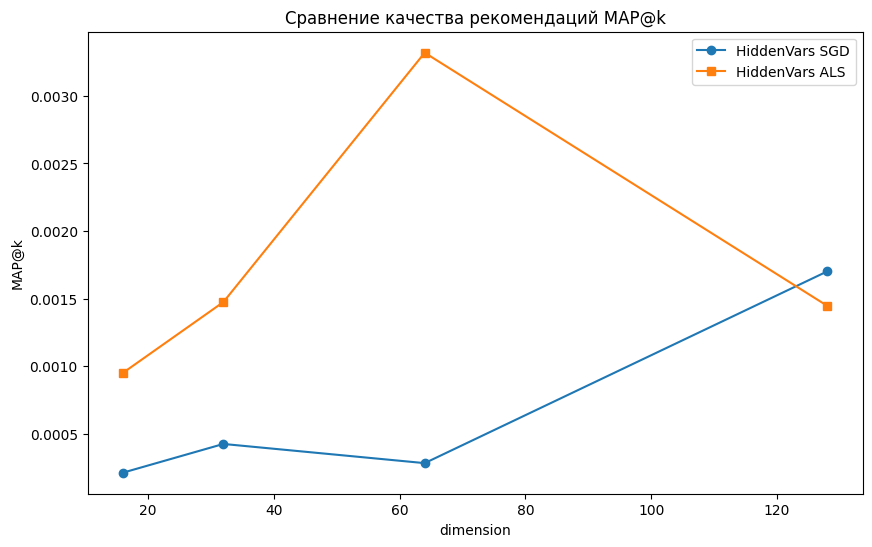

In [147]:
plt.figure(figsize=(10, 6))
plt.plot(dim_values, mapk_sgd, marker='o', label='HiddenVars SGD')
plt.plot(dim_values, mapk_als, marker='s', label='HiddenVars ALS')

plt.xlabel('dimension')
plt.ylabel('MAP@k')
plt.title('Сравнение качества рекомендаций MAP@k')
plt.legend()
plt.show()

Теперь для числа k попробуем

In [148]:
dim = 64

k_values = list(range(1,14))


mapk_sgd = []
mapk_als = []

for k in k_values:
    model_sgd = HiddenVars(train_ratings, dim, 'sgd')
    model_als = HiddenVars(train_ratings, dim, 'als')

    model_sgd.fit(num_iters=1)
    model_als.fit(num_iters=1)

    recomend_sgd = model_sgd.get_test_recommendations(k)
    recomend_als = model_als.get_test_recommendations(k)

    map_sgd = mapk(test_relevant, recomend_sgd, k)
    map_als = mapk(test_relevant, recomend_als, k)

    mapk_sgd.append(map_sgd)
    mapk_als.append(map_als)


100%|██████████| 1/1 [00:05<00:00,  5.26s/it]



Total training time: 5.27 seconds


100%|██████████| 1/1 [00:22<00:00, 22.16s/it]



Total training time: 22.17 seconds


<ipython-input-15-3316012668>:26: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]
100%|██████████| 1/1 [00:04<00:00,  4.65s/it]



Total training time: 4.65 seconds


100%|██████████| 1/1 [00:23<00:00, 23.23s/it]



Total training time: 23.23 seconds


100%|██████████| 1/1 [00:05<00:00,  5.44s/it]



Total training time: 5.44 seconds


100%|██████████| 1/1 [00:22<00:00, 23.00s/it]



Total training time: 23.00 seconds


100%|██████████| 1/1 [00:05<00:00,  5.89s/it]



Total training time: 5.89 seconds


100%|██████████| 1/1 [00:23<00:00, 23.13s/it]



Total training time: 23.13 seconds


100%|██████████| 1/1 [00:04<00:00,  4.72s/it]



Total training time: 4.72 seconds


100%|██████████| 1/1 [00:22<00:00, 22.88s/it]



Total training time: 22.88 seconds


100%|██████████| 1/1 [00:04<00:00,  4.97s/it]



Total training time: 4.98 seconds


100%|██████████| 1/1 [00:22<00:00, 22.56s/it]



Total training time: 22.57 seconds


100%|██████████| 1/1 [00:05<00:00,  5.36s/it]



Total training time: 5.37 seconds


100%|██████████| 1/1 [00:21<00:00, 21.77s/it]



Total training time: 21.77 seconds


100%|██████████| 1/1 [00:04<00:00,  4.52s/it]



Total training time: 4.52 seconds


100%|██████████| 1/1 [00:22<00:00, 22.46s/it]



Total training time: 22.46 seconds


100%|██████████| 1/1 [00:05<00:00,  5.70s/it]



Total training time: 5.70 seconds


100%|██████████| 1/1 [00:22<00:00, 22.74s/it]



Total training time: 22.74 seconds


100%|██████████| 1/1 [00:04<00:00,  4.90s/it]



Total training time: 4.90 seconds


100%|██████████| 1/1 [00:23<00:00, 23.55s/it]



Total training time: 23.55 seconds


100%|██████████| 1/1 [00:04<00:00,  4.46s/it]



Total training time: 4.47 seconds


100%|██████████| 1/1 [00:22<00:00, 22.50s/it]



Total training time: 22.51 seconds


100%|██████████| 1/1 [00:05<00:00,  5.80s/it]



Total training time: 5.80 seconds


100%|██████████| 1/1 [00:22<00:00, 22.20s/it]



Total training time: 22.20 seconds


100%|██████████| 1/1 [00:04<00:00,  4.70s/it]



Total training time: 4.70 seconds


100%|██████████| 1/1 [00:22<00:00, 22.14s/it]



Total training time: 22.14 seconds


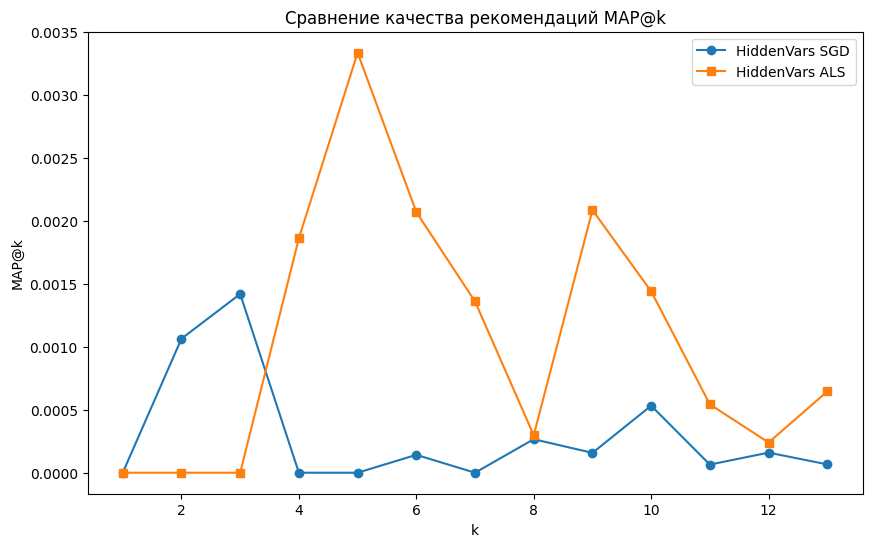

In [149]:
plt.figure(figsize=(10, 6))
plt.plot(k_values, mapk_sgd, marker='o', label='HiddenVars SGD')
plt.plot(k_values, mapk_als, marker='s', label='HiddenVars ALS')

plt.xlabel('k')
plt.ylabel('MAP@k')
plt.title('Сравнение качества рекомендаций MAP@k')
plt.legend()
plt.show()

In [150]:
num_iters_values = [1,2,3]
dim = 64
k = 5


mapk_sgd = []
mapk_als = []


for num_iters in num_iters_values:
    model_sgd = HiddenVars(train_ratings, dim, 'sgd')
    model_als = HiddenVars(train_ratings, dim, 'als')

    model_sgd.fit(num_iters=num_iters)
    model_als.fit(num_iters=num_iters)

    recomend_sgd = model_sgd.get_test_recommendations(k)
    recomend_als = model_als.get_test_recommendations(k)

    map_sgd = mapk(test_relevant, recomend_sgd, k)
    map_als = mapk(test_relevant, recomend_als, k)

    mapk_sgd.append(map_sgd)
    mapk_als.append(map_als)



100%|██████████| 1/1 [00:04<00:00,  4.70s/it]



Total training time: 4.71 seconds


100%|██████████| 1/1 [00:22<00:00, 22.38s/it]



Total training time: 22.38 seconds


<ipython-input-15-3316012668>:26: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]
100%|██████████| 2/2 [00:10<00:00,  5.14s/it]



Total training time: 10.29 seconds


100%|██████████| 2/2 [00:44<00:00, 22.41s/it]



Total training time: 44.82 seconds


100%|██████████| 3/3 [00:14<00:00,  4.96s/it]



Total training time: 14.89 seconds


100%|██████████| 3/3 [01:07<00:00, 22.37s/it]



Total training time: 67.12 seconds


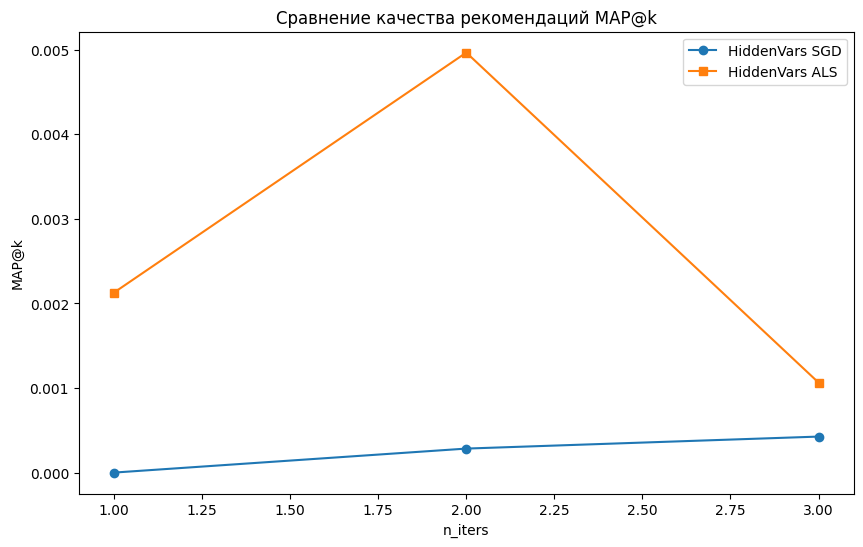

In [151]:
plt.figure(figsize=(10, 6))
plt.plot(num_iters_values, mapk_sgd, marker='o', label='HiddenVars SGD')
plt.plot(num_iters_values, mapk_als, marker='s', label='HiddenVars ALS')

plt.xlabel('n_iters')
plt.ylabel('MAP@k')
plt.title('Сравнение качества рекомендаций MAP@k')
plt.legend()
plt.show()

Ну, как мы можем заметить, сгд вообще в 0 улетело с такими параметрами, а вот als прям нормально так вырос по сранвнеию с user2user и остальными моделями.

Если у вас получилось достаточно хорошее качество, то при оптимизации параметров марицы $Q$ похожим трекам стали соответствовать похожие векторы. Поэтому мы можем для любого трека найти наиболее близкие к нему в латентном пространстве и проверить степерь обученности модели вручную.

In [152]:
model = HiddenVars(train_ratings, 64, 'als')
model.fit(num_iters=2)

100%|██████████| 2/2 [00:43<00:00, 21.94s/it]


Total training time: 43.88 seconds


In [155]:
example_trackId = tracks_info[tracks_info.name == 'Выхода нет'].iloc[0].id

preds = model.Q @ model.Q[example_trackId]
preds = preds / np.sqrt((model.Q**2).sum(axis=1) + 1e-8)

track_idxs = preds.argsort()[::-1][:20]

In [156]:
similar_tracks = tracks_info.loc[track_idxs][['name', 'artists']]
similar_tracks['similarity'] = preds[track_idxs] / np.linalg.norm(model.Q[example_trackId])
similar_tracks

,name,artists,similarity
5512,Выхода нет,['Сплин'],1.000000
2058,Последний герой,['КИНО'],0.689259
5570,Моё сердце,['Сплин'],0.675360
5153,Stormbringer,['Deep Purple'],0.648425
9689,Bicycle Race,['Queen'],0.648425
16637,Zodiac,['Zodiac'],0.648425
16224,Пока горит свеча,['Машина времени'],0.634265
26199,Скованные одной цепью,['Nautilus Pompilius'],0.606076
17331,"Последнее письмо (Гудбай, Америка)",['Nautilus Pompilius'],0.593424
3499,One More Time,['Daft Punk'],0.568560


Можем заметить, что достаточно хорошо получилось

**Бонус (1.5 балла).**

Постройте модель iALS и сравните ее качество с обучением ALS и SGD.

In [172]:

import numpy as np
from scipy.sparse import csr_matrix
from tqdm import tqdm

class HiddenVars(BaseModel):
    def __init__(self, ratings, dim=128, mode='sgd', alpha=40, epsilon=0.1):
        super().__init__(ratings)
        self.dim = dim
        assert mode in ['sgd', 'als', 'ials']
        self.mode = mode
        self.alpha = alpha
        self.epsilon = epsilon

        self.P = np.random.normal(size=(self.n_users, dim))
        self.Q = np.random.normal(size=(self.n_items, dim))

        self.lr = 0.0003
        self.lamb = 0.01

        self.R = csr_matrix(self.R)  # преобразуем в разреженную матрицу

    def fit(self, num_iters=5):
        start_time = time.time()

        for epoch in tqdm(range(num_iters)):
            epoch_start = time.time()

            if self.mode == 'sgd':
                users, items = self.R.nonzero()
                for u, i in zip(users, items):
                    r_ui = self.R[u, i]
                    pred = self.P[u] @ self.Q[i]
                    error = r_ui - pred
                    self.P[u] += self.lr * (error * self.Q[i] - self.lamb * self.P[u])
                    self.Q[i] += self.lr * (error * self.P[u] - self.lamb * self.Q[i])

            elif self.mode == 'als':
                R = self.R.tocsr()
                for u in range(self.n_users):
                    item_ids = R[u].indices
                    Q_i = self.Q[item_ids]
                    r_u = R[u, item_ids].toarray().flatten()
                    m1 = Q_i.T @ Q_i + self.lamb * np.eye(self.dim)
                    m2 = Q_i.T @ r_u
                    self.P[u] = np.linalg.solve(m1, m2)

                R_T = self.R.T.tocsr()
                for i in range(self.n_items):
                    user_ids = R_T[i].indices
                    P_u = self.P[user_ids]
                    r_i = R_T[i, user_ids].toarray().flatten()
                    m1 = P_u.T @ P_u + self.lamb * np.eye(self.dim)
                    m2 = P_u.T @ r_i
                    self.Q[i] = np.linalg.solve(m1, m2)

            elif self.mode == 'ials':

                C = (self.R > 0).astype(np.float32) * self.alpha


                for u in range(self.n_users):
                    item_ids = C[u].indices
                    c_u = C[u, item_ids].toarray().flatten()
                    Q_i = self.Q[item_ids]
                    m1 = Q_i.T @ (Q_i * c_u[:, None]) + self.epsilon * np.eye(self.dim)
                    m2 = Q_i.T @ c_u
                    self.P[u] = np.linalg.solve(m1, m2)


                C_T = C.T.tocsr()
                for i in range(self.n_items):
                    user_ids = C_T[i].indices
                    c_i = C_T[i, user_ids].toarray().flatten()
                    P_u = self.P[user_ids]
                    m1 = P_u.T @ (P_u * c_i[:, None]) + self.epsilon * np.eye(self.dim)
                    m2 = P_u.T @ c_i
                    self.Q[i] = np.linalg.solve(m1, m2)

        total_time = time.time() - start_time
        print(f"\nTotal training time: {total_time:.2f} seconds")

    def recommend(self, uid, k=10):
        pred_rating = self.P[uid] @ self.Q.T
        return np.argsort(pred_rating)[::-1][:k]

In [162]:
model = HiddenVars(train_ratings, 64, 'ials')
model.fit(num_iters=2)


100%|██████████| 2/2 [00:48<00:00, 24.09s/it]


Total training time: 48.18 seconds


In [163]:
example_trackId = tracks_info[tracks_info.name == 'Выхода нет'].iloc[0].id

preds = model.Q @ model.Q[example_trackId]
preds = preds / np.sqrt((model.Q**2).sum(axis=1) + 1e-8)

track_idxs = preds.argsort()[::-1][:20]

In [164]:
similar_tracks = tracks_info.loc[track_idxs][['name', 'artists']]
similar_tracks['similarity'] = preds[track_idxs] / np.linalg.norm(model.Q[example_trackId])
similar_tracks

,name,artists,similarity
5512,Выхода нет,['Сплин'],1.000000
6171,Billie Jean,['Michael Jackson'],0.677121
16637,Zodiac,['Zodiac'],0.674126
5153,Stormbringer,['Deep Purple'],0.674126
9689,Bicycle Race,['Queen'],0.674126
27828,Молодые ветра,['7Б'],0.658694
2058,Последний герой,['КИНО'],0.651867
16635,Pacific,['Zodiac'],0.647413
5005,Highway Star,['Deep Purple'],0.647413
44373,Do Your Worst,['Rival Sons'],0.647413


Заметим, что IALS тоже показал себя тоже неплохо, но по рекам наверное похуже чем als, но явно лучше SGD

### Часть 3. Второй уровень рекомендаций.

Выше мы построили простейшие модели, которые показывают не слишком высокое качество, но зато работают очень быстро. Воспользуемся ими для того, чтобы отобрать некоторое количество наиболее перспективных треков, которые мы сможем отранжировать уже более сложной моделью (в нашем случае это будет [CatBoost](https://catboost.ai/en/docs/concepts/python-reference_catboost)).

**Задание 9 (1 балл).**

Для каждого пользователя возьмите топ-100 рекомендованных треков от модели LFM (ALS или SGD на ваш выбор) и топ-100 от модели User2User. Это будут наши кандидаты, которые мы затем будем ранжировать бустингом.

In [175]:
model = HiddenVars(train_ratings, dim=64, mode='als')
model.fit(num_iters=2)




100%|██████████| 2/2 [00:45<00:00, 22.61s/it]


Total training time: 45.22 seconds


In [177]:
user_seen_items = train_ratings.groupby('userId')['trackId'].apply(set).to_dict()


from tqdm import tqdm

als_top100_recommendations = {}
for uid in tqdm(range(model.n_users)):

    raw_recs = model.recommend(uid, k=100)


    seen_items = user_seen_items.get(uid, set())
    filtered_recs = [item for item in raw_recs if item not in seen_items][:100]



    als_top100_recommendations[uid] = filtered_recs[:100]

# Пример вывода для первых 3 пользователей
for uid in list(als_top100_recommendations.keys())[:3]:
    print(f"\nUser {uid} top-5 recommendations:")
    print(tracks_info.loc[als_top100_recommendations[uid][:5], ['name', 'artists']])

100%|██████████| 241/241 [00:03<00:00, 74.60it/s] 


User 0 top-5 recommendations:
                   name                         artists
16231  Hotel California                      ['Eagles']
29169          Heathens           ['twenty one pilots']
4091       Karma Police                   ['Radiohead']
22155             Hello                        ['OMFG']
35972    Play with Fire  ['Sam Tinnesz', 'Yacht Money']

User 1 top-5 recommendations:
                          name          artists
29161             Russian Girl   ['Женя Любич']
1073   Smells Like Teen Spirit      ['Nirvana']
2814                      Numb  ['Linkin Park']

User 2 top-5 recommendations:
                         name                         artists
11493     The Show Must Go On                       ['Queen']
49577           Кукла колдуна                ['Король и Шут']
56031         Blinding Lights                  ['The Weeknd']
20094  Come And Get Your Love                     ['Redbone']
27822  Звезда по имени Солнце  ['Игорь Вдовин', 'Виктор Цой']


In [178]:
model_ials = HiddenVars(train_ratings, 64, 'ials')
model_ials.fit(num_iters=2)


100%|██████████| 2/2 [00:46<00:00, 23.09s/it]


Total training time: 46.19 seconds


In [180]:
user_seen_items = train_ratings.groupby('userId')['trackId'].apply(set).to_dict()


from tqdm import tqdm

als_top100_recommendations = {}
for uid in tqdm(range(model_ials.n_users)):

    raw_recs = model_ials.recommend(uid, k=100)


    seen_items = user_seen_items.get(uid, set())
    filtered_recs = [item for item in raw_recs if item not in seen_items][:100]



    als_top100_recommendations[uid] = filtered_recs[:100]

# Пример вывода для первых 3 пользователей
for uid in list(als_top100_recommendations.keys())[:3]:
    print(f"\nUser {uid} top-5 recommendations:")
    print(tracks_info.loc[als_top100_recommendations[uid][:5], ['name', 'artists']])

100%|██████████| 241/241 [00:03<00:00, 69.32it/s] 



User 0 top-5 recommendations:
                            name                artists
14763          Seven Nation Army  ['The White Stripes']
5521   Полковнику никто не пишет               ['Би-2']
10282           Владивосток 2000       ['Мумий Тролль']
23944                Трасса Е-95              ['Алиса']
6136                 Billie Jean    ['Michael Jackson']

User 1 top-5 recommendations:
                 name              artists
24500  Way Down We Go            ['KALEO']
2767   What I've Done      ['Linkin Park']
33436        Believer  ['Imagine Dragons']

User 2 top-5 recommendations:
                               name              artists
11950  Somebody That I Used To Know  ['Gotye', 'Kimbra']
17165             How You Remind Me       ['Nickelback']
18070                Dernière danse           ['Indila']
24500                Way Down We Go            ['KALEO']
53422                  Dance Monkey      ['Tones And I']


**Задание 10 (2 балла).**

Подготовьте датасет для обучения модели ранжирования. Он должен состоять из пар: объект, целевая переменная. Объект - это пара (user, item) и всякие дополнительные признаки на их основе. Предлагается создать набор следущих признаков, однако вы можете добавлять свои по желанию, если они вам кажутся разумными:
 1) id пользователя
 1) id трека
 1) косинусное расстояние между эмбеддингами LFM соответствующих пользователя и трека
 1) среднее значение меры Жаккара между этим пользователем и остальными из User2User модели
 1) доля пользователей, слушавших этот трек (взять из обучающей выборки в Части 1)
 1) количество прослушанных пользователем треков (взять из обучающей выборки в Части 1)

В качестве целевой переменной возьмем бинарную метку "попал ли трек в 50 последних прослушанных пользователем"

Разбейте полученную выборку на обучающую и тестовую в отношении 3:2 так, чтобы пропорции положительных и отрицательных примеров в обоих подвыборках были одинаковыми.

Как уже было сказано, для построения ранжирующей модели мы будем пользоваться библиотекой [CatBoost](https://www.youtube.com/watch?v=dQw4w9WgXcQ).

Для преобразования датасета в удобный вид полезно использовать метод [`Pool`](https://catboost.ai/en/docs/concepts/python-reference_pool).

In [ ]:
import catboost

# group_id == user_id here
train_pool = catboost.Pool(X_train, y_train, group_id=train_group_id)
test_pool = catboost.Pool(X_test, y_test, group_id=test_group_id)

**Задание 11 (1 балл)**

Обучите `CatBoostClassifier`. С его помощью сделайте предсказания для тестовой выборки и посчитайте MAP@20. Сравните с рекомендациями моделей User2User и LFM. Учтите, что для честного сравнения необходимо пересчитать предсказания моделей на нашей новой тестовой выборке. Получилось ли улучшить результаты?

In [ ]:
# your code here: (￣▽￣)/♫•*¨*•.¸¸♪

**Задание 12 (1 балл)**

Обучите `CatBoostRanker`, выбрав подходящую функцию ранжирования из тех, которые были рассмотрены на лекции. Проделайте все те же действия, что и с `CatBoostClassifier` и сравните результаты.

In [ ]:
# your code here: (￣▽￣)/♫•*¨*•.¸¸♪